TP1

Nom: Thierno Ibrahima Cissé
Code MS: CIST26029707

# Monter le drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exercice 1

##Sous-échantillonnage

(600, 600, 3)


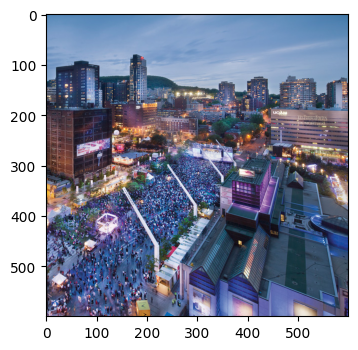

In [10]:
import imageio as imgio
import matplotlib.pyplot as plt

# Import and display the original image with infos
img = imgio.imread('/content/drive/MyDrive/Low_Level_Vision/data/tp1_ex1.jpg')
print(img.shape)
plt.figure(dpi=100); plt.imshow(img);

Text(0.5, 1.0, 'colored zoom of new image')

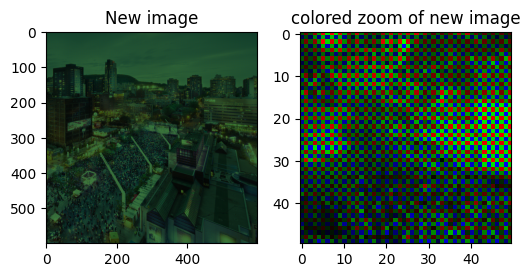

In [11]:
import numpy as np

srcArray = np.array(img, dtype=np.uint8)

# initialize grayscale downsampled array 
dsArray = colored = np.zeros((600,600), dtype=np.uint8)

# initialize colorized downsampled array
colored = np.zeros((600,600, 3), dtype=np.uint8)

# Red
colored[::2, 1::2, 0] = dsArray[::2, 1::2] = srcArray[::2, 1::2, 0]

# Green
colored[::2, ::2, 1] = dsArray[::2, ::2] = srcArray[::2, ::2, 1]
colored[1::2, 1::2, 1] = dsArray[1::2, 1::2] = srcArray[1::2, 1::2, 1]

# Blue
colored[1::2, ::2, 2] = dsArray[1::2, ::2] = srcArray[1::2, ::2, 2]

# Display
plt.figure(dpi=100)
plt.subplot(121); plt.imshow(colored); plt.title('New image')
plt.subplot(122); plt.imshow(colored[250:300, 250:300], ); plt.title('colored zoom of new image')

##Dématricage avec interpolation bilinéaire

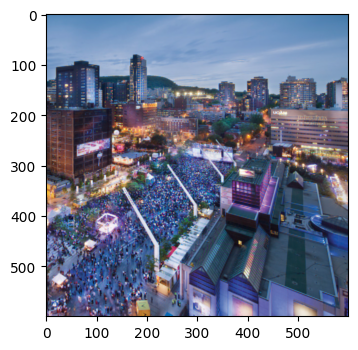

In [12]:
import cv2

# Demosaicing
debayering = cv2.demosaicing(dsArray, cv2.COLOR_BayerGR2BGR)

# display
plt.figure(dpi=100)
plt.imshow(debayering)

##Comparaison avec image initiale

Text(0.5, 1.0, 'difference')

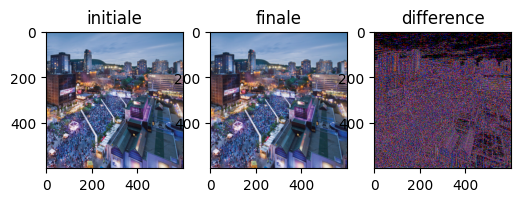

In [13]:
plt.figure(dpi=100)

plt.subplot(131); plt.imshow(img); plt.title('initiale')

plt.subplot(132); plt.imshow(debayering); plt.title('finale')

plt.subplot(133); plt.imshow(debayering - img); plt.title('difference')

Lorsque nous comparons à vu d'oeil de l'image reconstruite avec notre image initiale, nous constatons que les 2 images sont semblables. Cependant, en faisant la différence entre les 2 images nous remarquons beaucoup de pixels manquants sur l'image finale. Il y a donc une perte d'informations.


# Exercice 2

## Coordonnées de fréquence

(array([], dtype=int64), array([], dtype=int64))


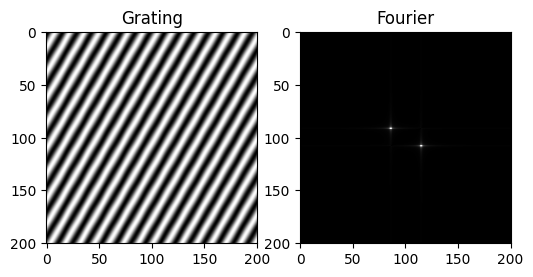

In [132]:
from scipy.fft import fft2, ifft2, fftshift, ifftshift

# display size
plt.figure(dpi=100)

# Sinusoidal grating
x = np.arange(-100, 101, 1)
X, Y = np.meshgrid(x, x)
wavelength = 12
angle = np.pi/6
grating = np.sin(2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength)
plt.subplot(121)
plt.imshow(grating, cmap='gray'); plt.title("Grating")

# Fourier transform of grating
ft = fftshift(fft2(ifftshift(grating)))
plt.subplot(122)
plt.imshow(np.abs(ft), cmap='gray'); plt.title("Fourier")

# coordinate
point = np.where(ft==255)
print(point)

##Transformation de Fourier, log de l'amplitude et phase

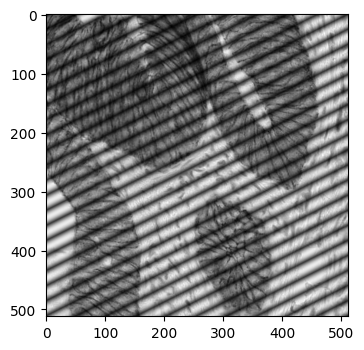

In [15]:
# Importer image
img2 = (imgio.imread('/content/drive/MyDrive/Low_Level_Vision/data/tp1_ex2.tif').astype(float))/255

plt.figure(dpi=100); plt.imshow(img2, cmap='gray');

Text(0.5, 1.0, 'Phase')

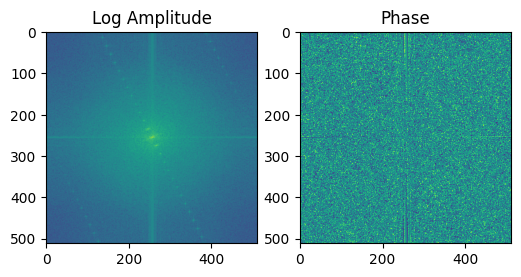

In [16]:
# Fourier
fourier = fftshift(fft2(img2))

# Amplitude et log
amplitude = np.sqrt((fourier.real)**2 + (fourier.imag)**2)
logAmplitude = np.log(amplitude)

# phase 
phase = np.arctan(fourier.imag/fourier.real)

# display
plt.figure(dpi=100)
plt.subplot(121); plt.imshow(logAmplitude); plt.title('Log Amplitude')
plt.subplot(122); plt.imshow(phase); plt.title('Phase')

## Comment retirer la dégradation périodique

Pour retirer la dégradation périodique, il est possible d'effectuer quelques traitements après calcul de notre Fast Fourier Transform. 
Nous allons calculer notre spectre et ensuite déterminer notre threshold pour filtrer les bruits. A l'aide d'un mask Hanning nous allons effectuer une convolution sur notre Fourier transformé. Enfin nous allons chercher notre Fast Fourier Transform inverse pour pouvoir retrouver notre image dans le domaine spatial.

#Exercice 3

## Algorithme Incrustation différentiel

In [126]:
!pip install scikit-video
from skimage import io as skio, transform
from skimage.color import rgb2gray as r2g, rgba2rgb as ra2g, gray2rgba as g2ra
from skimage.util import img_as_ubyte as imasbyte


# function that extract frames from video and return the list of frame
def frameLister(filepath, starting, ending):
  frameList = []
  for frame in range (starting, ending):
    timelapse = skio.imread(filepath, img_num = frame)                                  # extract the current frame
    frameList.append(timelapse.astype(float)/255)                                       # append the current frame to the list
  return(frameList)                                                                     # return the list of frame

# function that returns the median of multiple image to compute the background
def median_getter(imageList):
  medianbg = np.mean(imageList, axis=0)                                                 # Compute the mean of pixels on 0 axis
  return(medianbg)                                                                      # return the mean 

# function that returns the matting of an image
def matter(image, median, thresh):
  foreground = np.abs(image - median)                                                   # Compute the foreground of the image
  (t, alpha) = cv2.threshold(imasbyte(r2g(foreground)), thresh, 1, cv2.THRESH_BINARY)   # Compute the alpha of the foreground
  return(foreground, alpha)                                                             # return foreground array in rgb and alpha array grayscale

# function that returns the compositing with a new background of an image
def compositer(foreground, newBg, alpha):
  composite = (1-alpha) * r2g(ra2g(newBg)) + alpha * r2g(foreground)                    # Just apply the equation of compositing
  return(composite)                                                                     # Return the image with the new background

In [127]:
import skvideo.io

# path to the video we want to change background
videopath = '/content/drive/MyDrive/Low_Level_Vision/data/tp1_ex3_timelapse.tif'

# shape of the video
videoshape = skio.imread(videopath).shape

# path to the new background
checkerpath = '/content/drive/MyDrive/Low_Level_Vision/data/tp1_ex3_damier.png'

# open new background image
newBg = skio.imread(checkerpath).astype(float)/255

# resize new background image to the same size as the video
newBackground = transform.resize(newBg, output_shape=(videoshape[1],videoshape[2]))

# get all the frame of the video
allFrameList = frameLister(videopath, 0, videoshape[0])

# get only the empty frame of the video
emptyFrameList = frameLister(videopath, 127, videoshape[0])

# initialize the list of frame with the new bg
newFrameList = []

# Median of my old background
oldbackground = median_getter(emptyFrameList)

# Fixing the thresh
threshold = 10

# Matting and compositing for every frame
for currentFrame in allFrameList:
  (frameForeground, frameAlpha) = matter(currentFrame, oldbackground, threshold)            # Matting the current frame
  frameComposite = compositer(frameForeground, newBackground, frameAlpha)                   # compositing the current frame
  newFrameList.append(g2ra(imasbyte(frameComposite)))                                       # append the frame with new bg to the list

# generating video from the list of frame
skvideo.io.vwrite("output.mp4", newFrameList)                                               

## Explication des résultats et précisions sur les éléments détectés

Après exécution de notre algorithme nous voyons que l'arrière plan à été remplacé par l'image de damier dans notre video. Cependant, suivant la position des objets de notre avant-plan, nous constatons que certains pixels entourant les objets sont également détectés.
Notre algorithme détecte en majeur partie les oiseaux et quelques pixels en arrière-plan entourant ces derniers.

## Suggestion

Une méthode pour utiliser les pixels d'avant-plan détectés pour extraire des sous-images dans le but d'entraîner un modèle à reconnaitre les espèces d'oiseaux présents dans la vidéo serait décomposer les pixels et de voir la composition RGB de chacun. De ce fait nous pourrions les classer et conclure que ceux ayant la même composition RGB appartiennent à la même espèce d'oiseau.